#Impor Library

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

# Set style untuk visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

#Memuat Data

In [5]:
df = pd.read_csv('Dashboard_Data_v3.csv')
npl_df = pd.read_csv('Data-NPL_baru.csv')

display(df.head())
display(npl_df.head())

,kabupaten_kota,Garis_Kemiskinan,Indeks_Pembangunan_Manusia,Persen_Penduduk_Miskin,Tingkat Pengangguran Terbuka,Upah Minimum,Jumlah Penduduk (Ribu),Laju Pertumbuhan Penduduk per Tahun,Persentase Penduduk,Kepadatan Penduduk per km persegi (Km2),...,tahun,kuartal,PDRB,Proksi Inflasi,Laju_Inflasi,Gini_Ratio,investasi_per_kapita,Jumlah Perusahaan Kecil,Jumlah Perusahaan,Composite_Risk_Score_Normalized
0,BANGKALAN,458754,66.11,19.44,8.05,1956773.48,1081.75,1.25,2.62,954.5,...,2022,1.0,4144.62,Kota Surabaya,3.16,0.306,331.467391,38,357,0.705858
1,BANGKALAN,458754,66.11,19.44,8.05,1956773.48,1081.75,1.25,2.62,954.5,...,2022,2.0,4184.80,Kota Surabaya,4.89,0.306,986.404348,37,408,0.710334
2,BANGKALAN,458754,66.11,19.44,8.05,1956773.48,1081.75,1.25,2.62,954.5,...,2022,3.0,4481.15,Kota Surabaya,6.91,0.306,1527.247619,39,482,0.711605
3,BANGKALAN,458754,66.11,19.44,8.05,1956773.48,1081.75,1.25,2.62,954.5,...,2022,4.0,4149.34,Kota Surabaya,6.59,0.306,1103.961538,44,600,0.720735
4,BANGKALAN,503207,66.82,19.35,6.18,2240701.00,1091.80,1.07,2.63,839.0,...,2023,1.0,4304.99,Kota Surabaya,6.3,0.299,2403.400000,46,690,0.656412


,Tahun,Kuartal,NPL
0,2020,Q1,3.57
1,2020,Q2,3.79
2,2020,Q3,3.66
3,2020,Q4,3.91
4,2021,Q1,4.01


#Pra-Pemrosesan Data

In [6]:
# Menghilangkan kolom Composite Risk Score karena dataset yang digunakan dataset untuk dashboard
df = df.drop('Composite_Risk_Score_Normalized', axis=1)

In [7]:
# Convert 'Laju_Inflasi' to numeric by replacing commas with periods
df['Laju_Inflasi'] = df['Laju_Inflasi'].str.replace(',', '.', regex=False)
df['Laju_Inflasi'] = pd.to_numeric(df['Laju_Inflasi'])

##Interpolasi Linear

Melakukan interpolasi linear pada fitur yang seharusnya bergerak tiap triwulan namun hanya tersedia data tahunan

In [8]:
#List Kolom yang akan diinterpolasi
cols_to_interpolate = [
    'Garis_Kemiskinan',
    'Indeks_Pembangunan_Manusia',
    'Persen_Penduduk_Miskin',
    'Tingkat Pengangguran Terbuka',
    'Jumlah Penduduk (Ribu)',
    'Gini_Ratio'
]

In [9]:
#Mengelompokkan data berdasarkan kabupaten/kota, tahun, dan kuartal memastikan interpolasi linear dilakukan dengan benar
df = df.sort_values(by=['kabupaten_kota', 'tahun', 'kuartal']).reset_index(drop=True)

In [10]:
# Mengidentifikasi Kolom Kolom variabel yang konstan pada triwulan 2-4 lalu mengubahnya menjadi NaN
for col in cols_to_interpolate:
    df[col] = df.groupby(['kabupaten_kota', 'tahun'])[col].transform(lambda x: x if x.nunique() > 1 else x.where(x.index % 4 == 0))

# Mengaplikasikan interpolasi linear berdasarkan kabupaten/kota
for col in cols_to_interpolate:
    df[col] = df.groupby('kabupaten_kota')[col].transform(lambda x: x.interpolate(method='linear'))

display(df.head())

,kabupaten_kota,Garis_Kemiskinan,Indeks_Pembangunan_Manusia,Persen_Penduduk_Miskin,Tingkat Pengangguran Terbuka,Upah Minimum,Jumlah Penduduk (Ribu),Laju Pertumbuhan Penduduk per Tahun,Persentase Penduduk,Kepadatan Penduduk per km persegi (Km2),Rasio Jenis Kelamin Penduduk,tahun,kuartal,PDRB,Proksi Inflasi,Laju_Inflasi,Gini_Ratio,investasi_per_kapita,Jumlah Perusahaan Kecil,Jumlah Perusahaan
0,BANGKALAN,458754.00,66.1100,19.4400,8.0500,1956773.48,1081.7500,1.25,2.62,954.5,97.4,2022,1.0,4144.62,Kota Surabaya,3.16,0.30600,331.467391,38,357
1,BANGKALAN,469867.25,66.2875,19.4175,7.5825,1956773.48,1084.2625,1.25,2.62,954.5,97.4,2022,2.0,4184.80,Kota Surabaya,4.89,0.30425,986.404348,37,408
2,BANGKALAN,480980.50,66.4650,19.3950,7.1150,1956773.48,1086.7750,1.25,2.62,954.5,97.4,2022,3.0,4481.15,Kota Surabaya,6.91,0.30250,1527.247619,39,482
3,BANGKALAN,492093.75,66.6425,19.3725,6.6475,1956773.48,1089.2875,1.25,2.62,954.5,97.4,2022,4.0,4149.34,Kota Surabaya,6.59,0.30075,1103.961538,44,600
4,BANGKALAN,503207.00,66.8200,19.3500,6.1800,2240701.00,1091.8000,1.07,2.63,839.0,97.6,2023,1.0,4304.99,Kota Surabaya,6.30,0.29900,2403.400000,46,690


##Data NPL

In [11]:
#Mengubah format Kuartal menjadi numerik
npl_df['Kuartal'] = npl_df['Kuartal'].str.replace('Q', '').astype(float)
npl_df['Tahun'] = npl_df['Tahun'].astype(int)

##Pemisahan Data Berdasarkan Waktu (TRAIN-TEST SPLIT)

In [12]:
split_year = 2024
split_quarter = 1

train_mask = (df['tahun'] < split_year) | ((df['tahun'] == split_year) & (df['kuartal'] < split_quarter))
test_mask = ~train_mask

df_train = df[train_mask].reset_index(drop=True)
df_test = df[test_mask].reset_index(drop=True)

print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_test: {df_test.shape}\n")

Shape of df_train: (304, 20)
Shape of df_test: (152, 20)



#Analisis Data Explorasi (EDA)

In [13]:
# Menampilkan tipe data setiap kolom
print("Tipe Data:")
display(df.dtypes)

# Menampilkan informasi dasar dataset
print("\nInformasi Dataset:")
display(df.info())

# Menampilkan jumlah nilai yang hilang per kolom
print("\nJumlah Nilai Hilang:")
display(df.isnull().sum())

# Menampilkan statistik deskriptif untuk kolom numerik
print("\nStatistik Deskriptif:")
display(df.describe())

Tipe Data:


,0
kabupaten_kota,object
Garis_Kemiskinan,float64
Indeks_Pembangunan_Manusia,float64
Persen_Penduduk_Miskin,float64
Tingkat Pengangguran Terbuka,float64
Upah Minimum,float64
Jumlah Penduduk (Ribu),float64
Laju Pertumbuhan Penduduk per Tahun,float64
Persentase Penduduk,float64
Kepadatan Penduduk per km persegi (Km2),float64



Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   kabupaten_kota                           456 non-null    object 
 1   Garis_Kemiskinan                         456 non-null    float64
 2   Indeks_Pembangunan_Manusia               456 non-null    float64
 3   Persen_Penduduk_Miskin                   456 non-null    float64
 4   Tingkat Pengangguran Terbuka             456 non-null    float64
 5   Upah Minimum                             456 non-null    float64
 6   Jumlah Penduduk (Ribu)                   456 non-null    float64
 7   Laju Pertumbuhan Penduduk per Tahun      456 non-null    float64
 8   Persentase Penduduk                      456 non-null    float64
 9   Kepadatan Penduduk per km persegi (Km2)  456 non-null    float64
 10  Rasio Jenis Kelamin Penduduk  

None


Jumlah Nilai Hilang:


,0
kabupaten_kota,0
Garis_Kemiskinan,0
Indeks_Pembangunan_Manusia,0
Persen_Penduduk_Miskin,0
Tingkat Pengangguran Terbuka,0
Upah Minimum,0
Jumlah Penduduk (Ribu),0
Laju Pertumbuhan Penduduk per Tahun,0
Persentase Penduduk,0
Kepadatan Penduduk per km persegi (Km2),0



Statistik Deskriptif:


,Garis_Kemiskinan,Indeks_Pembangunan_Manusia,Persen_Penduduk_Miskin,Tingkat Pengangguran Terbuka,Upah Minimum,Jumlah Penduduk (Ribu),Laju Pertumbuhan Penduduk per Tahun,Persentase Penduduk,Kepadatan Penduduk per km persegi (Km2),Rasio Jenis Kelamin Penduduk,tahun,kuartal,PDRB,Laju_Inflasi,Gini_Ratio,investasi_per_kapita,Jumlah Perusahaan Kecil,Jumlah Perusahaan
count,456.000000,456.000000,456.000000,456.000000,4.560000e+02,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,4.560000e+02,456.000000,456.000000
mean,491495.836623,74.829068,10.065669,4.505143,2.752764e+06,1094.522259,0.998860,2.631491,1942.592105,99.231140,2023.000000,2.500000,12146.577654,3.707368,0.336922,2.456544e+11,192.837719,1119.868421
std,90285.040877,4.701514,4.215714,1.440583,8.291193e+05,675.079014,0.686418,1.623300,2215.167649,1.849412,0.817393,1.119262,19105.073838,1.836465,0.036420,3.102592e+12,456.248072,2736.189153
min,327758.000000,65.440000,3.060000,1.360000,1.922123e+06,134.700000,0.110000,0.330000,391.000000,93.650000,2022.000000,1.000000,1247.960000,0.880000,0.233000,2.088177e+00,10.000000,16.000000
25%,420334.000000,71.220000,6.661250,3.750000,2.238808e+06,698.618750,0.600000,1.680000,638.000000,98.000000,2022.000000,1.750000,3502.502500,2.290000,0.312375,1.425543e+02,40.000000,137.750000
50%,470713.000000,74.032500,9.450000,4.470000,2.410346e+06,1102.500000,0.795000,2.650000,875.000000,99.650000,2023.000000,2.500000,6148.985000,3.050000,0.335125,4.091647e+02,74.500000,458.500000
75%,548389.937500,78.055000,12.306250,5.301875,2.994144e+06,1345.381250,1.070000,3.250000,1352.000000,100.800000,2024.000000,3.250000,15095.227500,5.360000,0.356125,9.427386e+02,156.250000,969.000000
max,742678.000000,84.690000,21.760000,8.800000,4.961753e+06,2922.000000,4.040000,7.030000,8698.000000,101.950000,2024.000000,4.000000,124309.990000,7.390000,0.435000,5.688670e+13,4888.000000,27121.000000


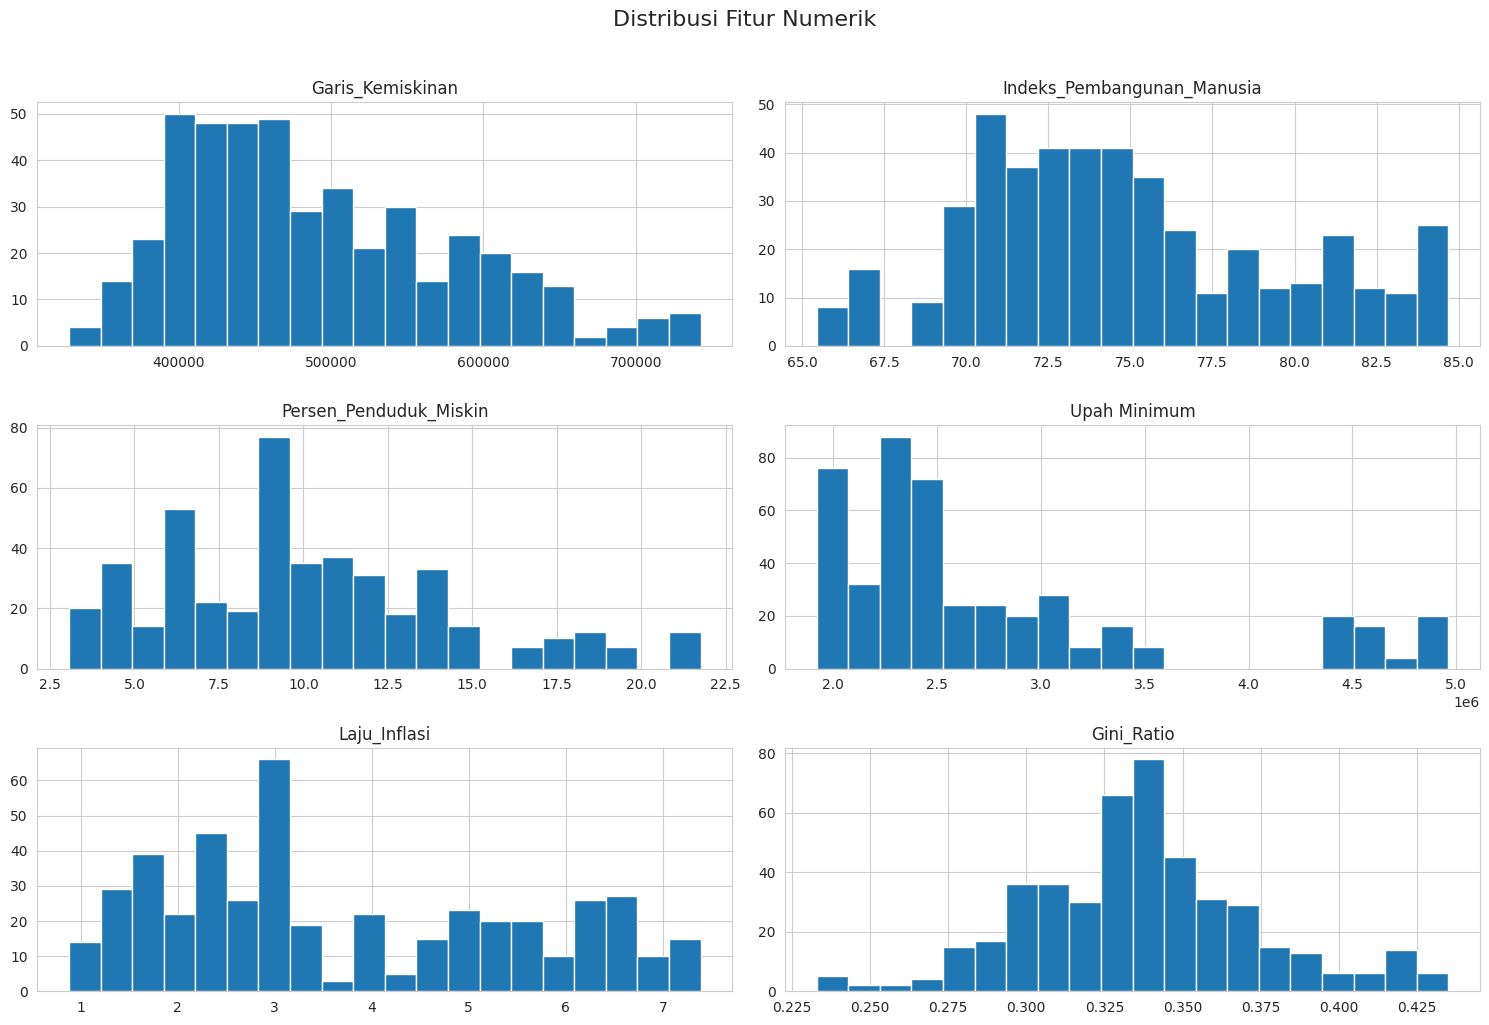

In [14]:
# Visualisasi distribusi beberapa kolom numerik penting (contoh)
numeric_cols_to_plot = ['Garis_Kemiskinan', 'Indeks_Pembangunan_Manusia', 'Persen_Penduduk_Miskin', 'Upah Minimum', 'Laju_Inflasi', 'Gini_Ratio']
df[numeric_cols_to_plot].hist(figsize=(15, 10), bins=20)
plt.suptitle('Distribusi Fitur Numerik', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

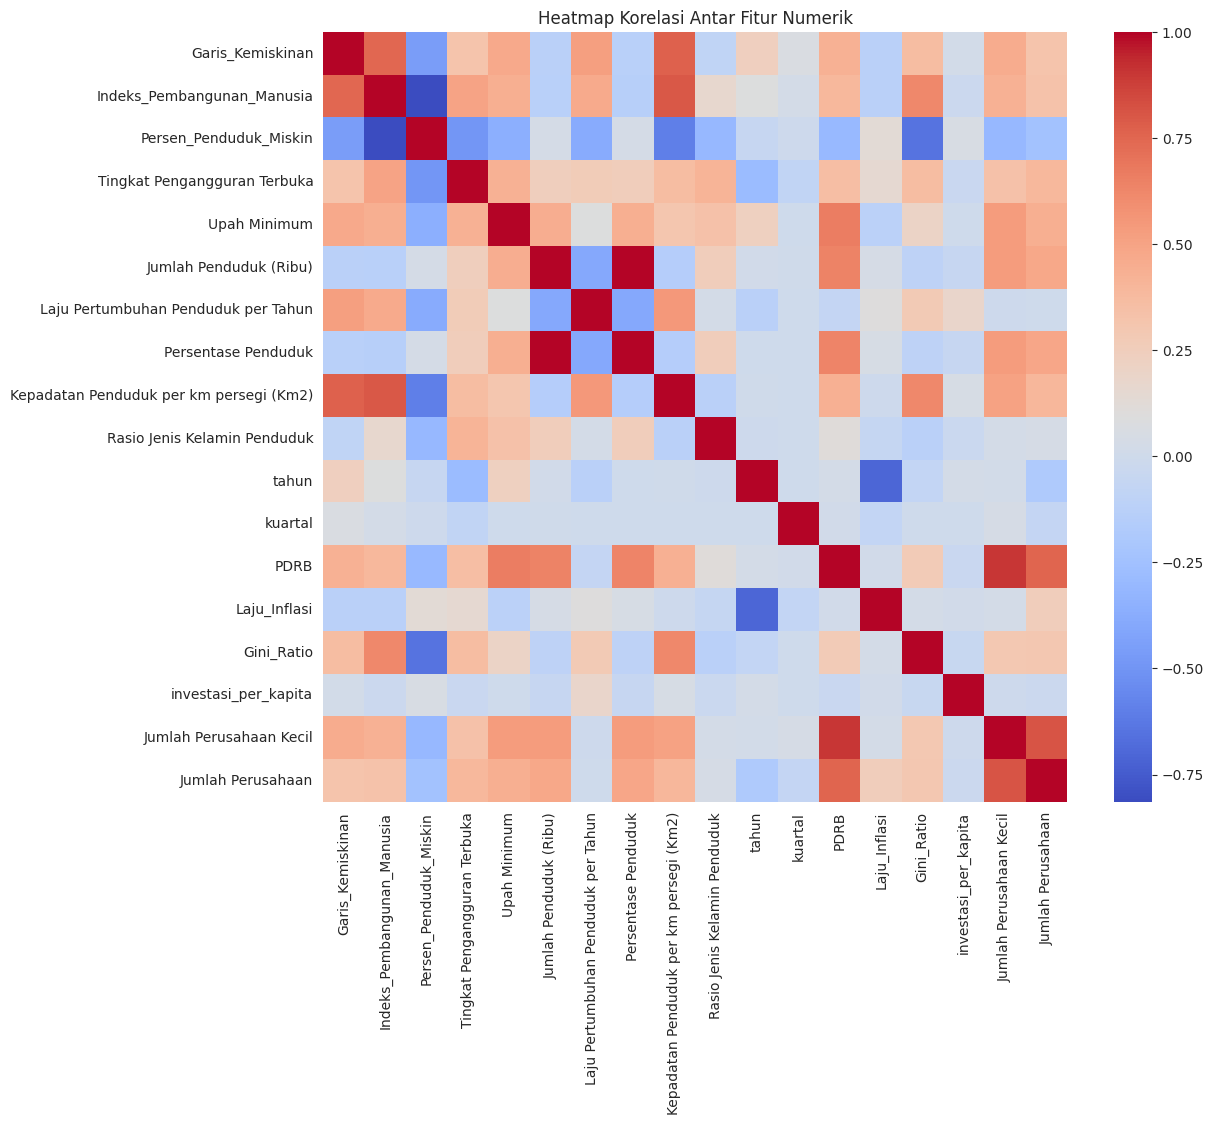

In [15]:
# Visualisasi korelasi antar fitur numerik
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=False, cmap='coolwarm')
plt.title('Heatmap Korelasi Antar Fitur Numerik')
plt.show()

#Pemodelan

##Principal Component Analysis

In [16]:
# Memilih kolom numerik untuk PCA
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
exclude_cols = ['tahun', 'kuartal','Jumlah Perusahaan Kecil','Jumlah Perusahaan','nama_kabupaten_kota','Laju_Inflasi']
pca_cols = [col for col in numeric_cols if col not in exclude_cols]

Standarisasi dan PCA hanya dilakukan pada data training, ini mencegah terjadinya data leakage

In [17]:
#Standarisasi pada data training
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train[pca_cols])

In [18]:
#Mengaplikasikan PCA pada data training yang sudah distandardisasi
pca = PCA()
pca.fit(df_train_scaled)
#Menentukan jumlah komponen untuk menjelaskan >= 90% varians berdasarkan data training
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Jumlah komponen yang menjelaskan >= 90% varians berdasarkan data training: {n_components}\n")

# Ulangi PCA dengan n_components yang optimal, lalu fit pada training dan transform pada train & test
pca = PCA(n_components=n_components)
pca_scores_train = pca.fit_transform(df_train_scaled) # Fit dan transform di data training
df_test_scaled = scaler.transform(df_test[pca_cols]) # Mentransformasikan data testing menggunakan skala yang digunakan di data training
pca_scores_test = pca.transform(df_test_scaled) # Mentransformasikan data testing menggunakan PCA yang digunakan di training


# Membuat DataFrame hasil PCA untuk training dan testing
pca_columns = [f'PC{i+1}' for i in range(n_components)]

pca_df_train = pd.DataFrame(pca_scores_train, columns=pca_columns)
pca_df_train = pd.concat([df_train[['kabupaten_kota', 'tahun', 'kuartal']].reset_index(drop=True), pca_df_train], axis=1)
pca_df_test = pd.DataFrame(pca_scores_test, columns=pca_columns)
pca_df_test = pd.concat([df_test[['kabupaten_kota', 'tahun', 'kuartal']].reset_index(drop=True), pca_df_test], axis=1)

display (pca_df_train.head())
display (pca_df_test.head())

Jumlah komponen yang menjelaskan >= 90% varians berdasarkan data training: 6



,kabupaten_kota,tahun,kuartal,PC1,PC2,PC3,PC4,PC5,PC6
0,BANGKALAN,2022,1.0,-1.842970,0.102720,-0.293791,0.280448,-0.802918,3.202456
1,BANGKALAN,2022,2.0,-1.886066,0.040422,-0.422713,0.294846,-0.890324,2.956475
2,BANGKALAN,2022,3.0,-1.925635,-0.016972,-0.556232,0.309126,-0.978421,2.708688
3,BANGKALAN,2022,4.0,-1.973853,-0.086390,-0.678479,0.323695,-1.064824,2.465327
4,BANGKALAN,2023,1.0,-1.992473,0.062823,-0.735543,0.364252,-1.217698,2.062935


,kabupaten_kota,tahun,kuartal,PC1,PC2,PC3,PC4,PC5,PC6
0,BANGKALAN,2024,1.0,-1.802362,-0.009876,-0.965653,0.384913,-1.411601,1.513912
1,BANGKALAN,2024,2.0,-1.800960,-0.007926,-0.967481,0.384866,-1.411876,1.513195
2,BANGKALAN,2024,3.0,-1.799826,-0.006350,-0.968958,0.384828,-1.412098,1.512615
3,BANGKALAN,2024,4.0,-1.803523,-0.011489,-0.964140,0.384951,-1.411374,1.514506
4,BANYUWANGI,2024,1.0,-0.350715,1.458134,0.305576,0.068356,0.000571,-0.670902


###Identifikasi PC Loading

In [19]:
#DataFrame untuk melihat loadings
loadings_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=pca_cols
)

#Tampilkan loadings untuk semua PC
print("PCA Loadings (All Components):")
display(loadings_df)

PCA Loadings (All Components):


,PC1,PC2,PC3,PC4,PC5,PC6
Garis_Kemiskinan,0.361256,-0.104907,-0.251388,0.056462,-0.428767,0.089626
Indeks_Pembangunan_Manusia,0.414969,-0.091095,0.063922,-0.069408,0.027454,-0.104631
Persen_Penduduk_Miskin,-0.364556,0.037872,-0.276395,0.113199,-0.329966,0.248116
Tingkat Pengangguran Terbuka,0.294000,0.166986,0.333582,0.000689,0.022728,0.829347
Upah Minimum,0.272689,0.292367,-0.009752,0.160034,-0.319477,-0.336555
Jumlah Penduduk (Ribu),0.019790,0.528640,-0.121906,0.034105,0.086164,0.060891
Laju Pertumbuhan Penduduk per Tahun,0.275225,-0.322620,0.057008,0.202492,-0.282689,0.018743
Persentase Penduduk,0.019367,0.528695,-0.121469,0.033278,0.088148,0.064340
Kepadatan Penduduk per km persegi (Km2),0.384070,-0.142098,-0.251809,-0.029881,0.004512,0.090006
Rasio Jenis Kelamin Penduduk,0.089407,0.213508,0.725272,0.131573,-0.161595,-0.269338


Interpretasi PC Loading

PC1: Faktor Pembangunan Ekonomi

PC2: Faktor Populasi dan Pertumbuhan Demografi

PC3: Faktor Ketidakseimbangan Demografi dan Ekonomi

PC4: Faktor Investasi dan Pertumbuhan

PC5: Faktor Ketimpangan dan Kemiskinan Struktural

PC6: Faktor Pengangguran dan Demografi

###Menyesuaikan Arah Risiko Berdasarkan Interpretasi Loadings

In [20]:
#Daftar PC yang akan dibalik tandanya berdasarkan analisis interpretasi, PC yang bernilai tinggi menandakan RISIKO RENDAH, sehingga perlu diinversi.
pcs_to_invert = ['PC1', 'PC2', 'PC4']

In [21]:
# Melakukan inversi tanda pada DataFrame train dan test
for pc in pcs_to_invert:
    if pc in pca_df_train.columns: # Use pca_df_train
        pca_df_train[pc] = pca_df_train[pc] * -1 # Use pca_df_train
        pca_df_test[pc] = pca_df_test[pc] * -1 # Use pca_df_test
        print(f"Arah untuk {pc} telah dibalik.")

print("\nArah PC setelah disesuaikan:")
display(pca_df_train.head())
display(pca_df_test.head())

Arah untuk PC1 telah dibalik.
Arah untuk PC2 telah dibalik.
Arah untuk PC4 telah dibalik.

Arah PC setelah disesuaikan:


,kabupaten_kota,tahun,kuartal,PC1,PC2,PC3,PC4,PC5,PC6
0,BANGKALAN,2022,1.0,1.842970,-0.102720,-0.293791,-0.280448,-0.802918,3.202456
1,BANGKALAN,2022,2.0,1.886066,-0.040422,-0.422713,-0.294846,-0.890324,2.956475
2,BANGKALAN,2022,3.0,1.925635,0.016972,-0.556232,-0.309126,-0.978421,2.708688
3,BANGKALAN,2022,4.0,1.973853,0.086390,-0.678479,-0.323695,-1.064824,2.465327
4,BANGKALAN,2023,1.0,1.992473,-0.062823,-0.735543,-0.364252,-1.217698,2.062935


,kabupaten_kota,tahun,kuartal,PC1,PC2,PC3,PC4,PC5,PC6
0,BANGKALAN,2024,1.0,1.802362,0.009876,-0.965653,-0.384913,-1.411601,1.513912
1,BANGKALAN,2024,2.0,1.800960,0.007926,-0.967481,-0.384866,-1.411876,1.513195
2,BANGKALAN,2024,3.0,1.799826,0.006350,-0.968958,-0.384828,-1.412098,1.512615
3,BANGKALAN,2024,4.0,1.803523,0.011489,-0.964140,-0.384951,-1.411374,1.514506
4,BANYUWANGI,2024,1.0,0.350715,-1.458134,0.305576,-0.068356,0.000571,-0.670902


##Konstruksi Composite Risk Score

In [22]:
#Memuat bobot varians dari PCA yang sudah di-fit pada data latih
variance_ratios = pca.explained_variance_ratio_

#Hitung CRS untuk data latih dan data uji
pca_df_train['Composite_Risk_Score'] = pca_df_train[pca_columns].dot(variance_ratios)
pca_df_test['Composite_Risk_Score'] = pca_df_test[pca_columns].dot(variance_ratios)

###Melakukan Standarisasi Composite Risk Score pada Data Latih dan Data Uji

In [23]:
scaler_risk = StandardScaler()
pca_df_train['Composite_Risk_Score_Normalized'] = scaler_risk.fit_transform(pca_df_train[['Composite_Risk_Score']])
pca_df_test['Composite_Risk_Score_Normalized'] = scaler_risk.transform(pca_df_test[['Composite_Risk_Score']])

print("Composite Risk Score berhasil dihitung dan dinormalisasi.")
display(pca_df_train.head())
display(pca_df_test.head())

Composite Risk Score berhasil dihitung dan dinormalisasi.


,kabupaten_kota,tahun,kuartal,PC1,PC2,PC3,PC4,PC5,PC6,Composite_Risk_Score,Composite_Risk_Score_Normalized
0,BANGKALAN,2022,1.0,1.842970,-0.102720,-0.293791,-0.280448,-0.802918,3.202456,0.687982,0.705858
1,BANGKALAN,2022,2.0,1.886066,-0.040422,-0.422713,-0.294846,-0.890324,2.956475,0.692345,0.710334
2,BANGKALAN,2022,3.0,1.925635,0.016972,-0.556232,-0.309126,-0.978421,2.708688,0.693584,0.711605
3,BANGKALAN,2022,4.0,1.973853,0.086390,-0.678479,-0.323695,-1.064824,2.465327,0.702483,0.720735
4,BANGKALAN,2023,1.0,1.992473,-0.062823,-0.735543,-0.364252,-1.217698,2.062935,0.639789,0.656412


,kabupaten_kota,tahun,kuartal,PC1,PC2,PC3,PC4,PC5,PC6,Composite_Risk_Score,Composite_Risk_Score_Normalized
0,BANGKALAN,2024,1.0,1.802362,0.009876,-0.965653,-0.384913,-1.411601,1.513912,0.530272,0.544049
1,BANGKALAN,2024,2.0,1.800960,0.007926,-0.967481,-0.384866,-1.411876,1.513195,0.529030,0.542775
2,BANGKALAN,2024,3.0,1.799826,0.006350,-0.968958,-0.384828,-1.412098,1.512615,0.528026,0.541745
3,BANGKALAN,2024,4.0,1.803523,0.011489,-0.964140,-0.384951,-1.411374,1.514506,0.531300,0.545104
4,BANYUWANGI,2024,1.0,0.350715,-1.458134,0.305576,-0.068356,0.000571,-0.670902,-0.231665,-0.237684


#Pemeriksaan Asumsi

## Fungsi untuk agregasi CRS Kabupaten/Kota berdasarkan bobot PDRB

In [24]:
def aggregate_risk_by_pdrb_weight(df: pd.DataFrame) -> pd.DataFrame:

    df_copy = df.copy()
    total_pdrb_per_period = df_copy.groupby(['tahun', 'kuartal'])['PDRB'].transform('sum')
    df_copy['pdrb_proportion'] = df_copy['PDRB'] / total_pdrb_per_period

    df_copy['weighted_risk_score'] = df_copy['Composite_Risk_Score_Normalized'] * df_copy['pdrb_proportion']

    agg_df = df_copy.groupby(['tahun', 'kuartal'])['weighted_risk_score'].sum().reset_index()

    agg_df = agg_df.rename(columns={'weighted_risk_score': 'Provincial_Weighted_Risk_Score'})

    return agg_df

pca_df_train_with_pdrb = pca_df_train.merge(df_train[['kabupaten_kota', 'tahun', 'kuartal', 'PDRB']],
                                            on=['kabupaten_kota', 'tahun', 'kuartal'],
                                            how='left')
pca_df_test_with_pdrb = pca_df_test.merge(df_test[['kabupaten_kota', 'tahun', 'kuartal', 'PDRB']],
                                          on=['kabupaten_kota', 'tahun', 'kuartal'],
                                          how='left')


agg_risk_train = aggregate_risk_by_pdrb_weight(pca_df_train_with_pdrb)
agg_risk_test = aggregate_risk_by_pdrb_weight(pca_df_test_with_pdrb)

# Tampilkan hasil
print("Hasil Agregasi Tertimbang (Train Set):")
print(agg_risk_train)

Hasil Agregasi Tertimbang (Train Set):
   tahun  kuartal  Provincial_Weighted_Risk_Score
0   2022      1.0                       -1.162259
1   2022      2.0                       -1.187611
2   2022      3.0                       -1.222984
3   2022      4.0                       -1.276813
4   2023      1.0                       -1.403092
5   2023      2.0                       -1.402520
6   2023      3.0                       -1.403941
7   2023      4.0                       -1.439530


In [25]:
province_composite_risk_score = pd.concat([agg_risk_train, agg_risk_test]).reset_index(drop=True)
province_composite_risk_score.rename(columns={'Composite_Risk_Score_Normalized': 'Aggregated_Composite_Risk_Score_Province'}, inplace=True)

##Visualisasi Hubungan CRS dan NPL 2 Kuartal Berikutnya

In [26]:
# Persiapan untuk Korelasi dengan NPL (Lag 2 Kuartal)
province_composite_risk_score['NPL_Year'] = province_composite_risk_score['tahun']
province_composite_risk_score['NPL_Quarter'] = province_composite_risk_score['kuartal'] + 2

# Penyesuaian untuk kuartal > 4
province_composite_risk_score['NPL_Year'] = province_composite_risk_score['NPL_Year'] + (province_composite_risk_score['NPL_Quarter'] > 4).astype(int)
province_composite_risk_score['NPL_Quarter'] = province_composite_risk_score['NPL_Quarter'] % 4
province_composite_risk_score['NPL_Quarter'] = province_composite_risk_score['NPL_Quarter'].replace(0, 4)

# Gabungkan dengan data NPL
merged_correlation_df = province_composite_risk_score.merge(npl_df, left_on=['NPL_Year', 'NPL_Quarter'], right_on=['Tahun', 'Kuartal'], how='inner')

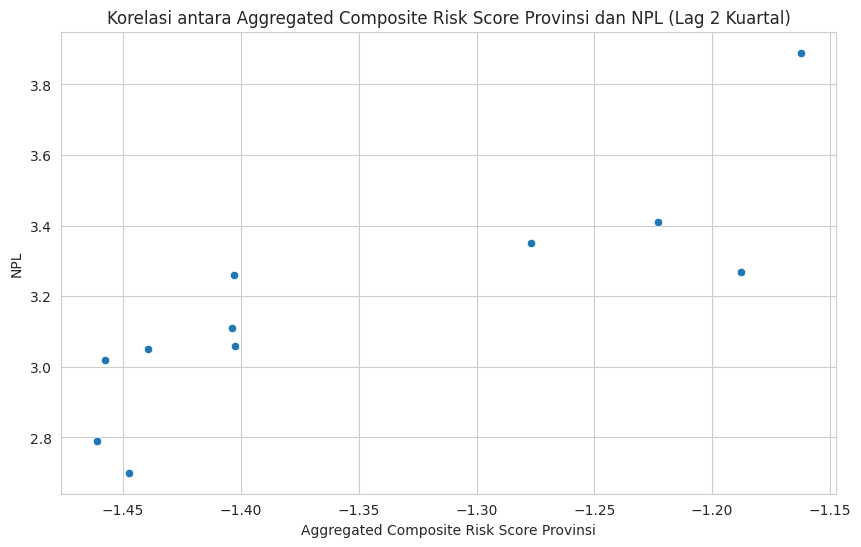

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_correlation_df, x='Provincial_Weighted_Risk_Score', y='NPL')
plt.title('Korelasi antara Aggregated Composite Risk Score Provinsi dan NPL (Lag 2 Kuartal)')
plt.xlabel('Aggregated Composite Risk Score Provinsi')
plt.ylabel('NPL')
plt.show()

##Korelasi Pearson Dan Spearman

In [28]:
# Korelasi Pearson
pearson_corr, pearson_p_value = pearsonr(merged_correlation_df['Provincial_Weighted_Risk_Score'], merged_correlation_df['NPL'])
print(f"Pearson Korelasi antara Aggregated Composite Risk Score Provinsi dan NPL (lag 2 kuartal): {pearson_corr:.4f}")
print(f"Pearson P-value: {pearson_p_value:.4f}\n")

# Korelasi Spearman
spearman_corr, spearman_p_value = spearmanr(merged_correlation_df['Provincial_Weighted_Risk_Score'], merged_correlation_df['NPL'])
print(f"Spearman Korelasi antara Aggregated Composite Risk Score Provinsi dan NPL (lag 2 kuartal): {spearman_corr:.4f}")
print(f"Spearman P-value: {spearman_p_value:.6f}\n")

# Menampilkan data yang digunakan untuk korelasi
print("Data yang Digunakan untuk Korelasi:")
display(merged_correlation_df[['tahun', 'kuartal', 'Provincial_Weighted_Risk_Score', 'NPL_Year', 'NPL_Quarter', 'NPL']])

Pearson Korelasi antara Aggregated Composite Risk Score Provinsi dan NPL (lag 2 kuartal): 0.8433
Pearson P-value: 0.0011

Spearman Korelasi antara Aggregated Composite Risk Score Provinsi dan NPL (lag 2 kuartal): 0.9182
Spearman P-value: 0.000067

Data yang Digunakan untuk Korelasi:


,tahun,kuartal,Provincial_Weighted_Risk_Score,NPL_Year,NPL_Quarter,NPL
0,2022,1.0,-1.162259,2022,3.0,3.89
1,2022,2.0,-1.187611,2022,4.0,3.27
2,2022,3.0,-1.222984,2023,1.0,3.41
3,2022,4.0,-1.276813,2023,2.0,3.35
4,2023,1.0,-1.403092,2023,3.0,3.26
5,2023,2.0,-1.402520,2023,4.0,3.06
6,2023,3.0,-1.403941,2024,1.0,3.11
7,2023,4.0,-1.439530,2024,2.0,3.05
8,2024,1.0,-1.461314,2024,3.0,2.79
9,2024,2.0,-1.447515,2024,4.0,2.70


##Korelasi CRS dengan Jumlah Perusahaan Kecil

In [29]:
# Merge the pca_df_train and pca_df_test with the original df to get 'Jumlah Perusahaan Kecil'
df_with_risk = pd.concat([pca_df_train, pca_df_test]).reset_index(drop=True)

# Prepare 'Jumlah Perusahaan Kecil' data for the next quarter
df_jpk = df[['kabupaten_kota', 'tahun', 'kuartal', 'Jumlah Perusahaan Kecil']].copy()
df_jpk['kuartal_next'] = df_jpk['kuartal'] + 1
df_jpk['tahun_next'] = df_jpk['tahun']

# Adjust year and quarter for the next period
df_jpk['tahun_next'] = df_jpk.apply(lambda row: row['tahun_next'] + 1 if row['kuartal_next'] > 4 else row['tahun_next'], axis=1)
df_jpk['kuartal_next'] = df_jpk.apply(lambda row: row['kuartal_next'] % 4 if row['kuartal_next'] > 4 else row['kuartal_next'], axis=1)
df_jpk['kuartal_next'] = df_jpk['kuartal_next'].replace(0, 4)


# Merge risk scores with next quarter's 'Jumlah Perusahaan Kecil'
df_merged_jpk = df_with_risk.merge(df_jpk[['kabupaten_kota', 'tahun_next', 'kuartal_next', 'Jumlah Perusahaan Kecil']],
                                   left_on=['kabupaten_kota', 'tahun', 'kuartal'],
                                   right_on=['kabupaten_kota', 'tahun_next', 'kuartal_next'],
                                   how='inner')

# Drop the redundant year_next and quarter_next columns after merging
df_merged_jpk = df_merged_jpk.drop(columns=['tahun_next', 'kuartal_next'])


# Korelasi Pearson, pastikan tidak ada NaN dalam kolom yang digunakan
df_merged_jpk_cleaned = df_merged_jpk.dropna(subset=['Composite_Risk_Score_Normalized', 'Jumlah Perusahaan Kecil'])
pearson_corr_jpk, pearson_p_value_jpk = pearsonr(df_merged_jpk_cleaned['Composite_Risk_Score_Normalized'], df_merged_jpk_cleaned['Jumlah Perusahaan Kecil'])
print(f"Pearson Korelasi antara Composite Risk Score dan Jumlah Perusahaan Kecil (Lag 1 Kuartal): {pearson_corr_jpk:.4f}")
print(f"Pearson P-value: {pearson_p_value_jpk:.4f}\n")

# Korelasi Spearman
spearman_corr_jpk, spearman_p_value_jpk = spearmanr(df_merged_jpk_cleaned['Composite_Risk_Score_Normalized'], df_merged_jpk_cleaned['Jumlah Perusahaan Kecil'])
print(f"Spearman Korelasi antara Composite Risk Score dan Jumlah Perusahaan Kecil (Lag 1 Kuartal): {spearman_corr_jpk:.4f}")
print(f"Spearman P-value: {spearman_p_value_jpk:.4f}\n")

# Display the data used for correlation
print("Data yang Digunakan untuk Korelasi (Lag 1 Kuartal):")
display(df_merged_jpk_cleaned[['kabupaten_kota', 'tahun', 'kuartal', 'Composite_Risk_Score_Normalized', 'Jumlah Perusahaan Kecil']].head())

Pearson Korelasi antara Composite Risk Score dan Jumlah Perusahaan Kecil (Lag 1 Kuartal): -0.8055
Pearson P-value: 0.0000

Spearman Korelasi antara Composite Risk Score dan Jumlah Perusahaan Kecil (Lag 1 Kuartal): -0.7369
Spearman P-value: 0.0000

Data yang Digunakan untuk Korelasi (Lag 1 Kuartal):


,kabupaten_kota,tahun,kuartal,Composite_Risk_Score_Normalized,Jumlah Perusahaan Kecil
0,BANGKALAN,2022,2.0,0.710334,38
1,BANGKALAN,2022,3.0,0.711605,37
2,BANGKALAN,2022,4.0,0.720735,39
3,BANGKALAN,2023,1.0,0.656412,44
4,BANGKALAN,2023,2.0,0.641035,46


#Membangun Surrogate Model dengan XGBoost

##Mendefinisikan Fitur dan Target secara Terpisah

In [30]:
#Definisikan Fitur (X) dari df_train dan df_test
exclude_cols = ['kabupaten_kota', 'tahun', 'kuartal', 'Proksi Inflasi','Jumlah Perusahaan','nama_kabupaten_kota','Jumlah Perusahaan Kecil']
X_train = df_train.drop(columns=exclude_cols, errors='ignore')
X_test = df_test.drop(columns=exclude_cols, errors='ignore')

#Definisikan Target (y) dari pca_df_train dan pca_df_test
y_train = pca_df_train['Composite_Risk_Score_Normalized']
y_test = pca_df_test['Composite_Risk_Score_Normalized']

print("Dimensi X_train:", X_train.shape)
print("Dimensi y_train:", y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi y_test:", y_test.shape)

Dimensi X_train: (304, 14)
Dimensi y_train: (304,)
Dimensi X_test: (152, 14)
Dimensi y_test: (152,)


##Standarisasi Fitur

In [31]:
#Inisialisasi StandardScaler
scaler_X = StandardScaler()

#Langkah ini mengajarkan scaler tentang distribusi statistik data latih.
X_train_scaled = scaler_X.fit_transform(X_train)

#Gunakan scaler yang dipelajari data latih untuk transformasi data uji.
X_test_scaled = scaler_X.transform(X_test)

#Memastikan X_train dan X_test siap digunakan untuk melatih model.
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\n--- X_train dan X_test yang sudah dinormalisasi---")
display(X_train.head())
display(X_test.head())


--- X_train dan X_test yang sudah dinormalisasi---


,Garis_Kemiskinan,Indeks_Pembangunan_Manusia,Persen_Penduduk_Miskin,Tingkat Pengangguran Terbuka,Upah Minimum,Jumlah Penduduk (Ribu),Laju Pertumbuhan Penduduk per Tahun,Persentase Penduduk,Kepadatan Penduduk per km persegi (Km2),Rasio Jenis Kelamin Penduduk,PDRB,Laju_Inflasi,Gini_Ratio,investasi_per_kapita
0,-0.242189,-1.812233,2.182433,2.198595,-0.852097,-0.014630,0.179736,-0.007140,-0.447794,-0.987743,-0.415743,-0.856993,-0.930356,-0.07547
1,-0.115873,-1.774293,2.177115,1.888344,-0.852097,-0.010894,0.179736,-0.007140,-0.447794,-0.987743,-0.413575,0.209776,-0.978992,-0.07547
2,0.010443,-1.736352,2.171796,1.578094,-0.852097,-0.007159,0.179736,-0.007140,-0.447794,-0.987743,-0.397590,1.455366,-1.027629,-0.07547
3,0.136758,-1.698412,2.166477,1.267843,-0.852097,-0.003423,0.179736,-0.007140,-0.447794,-0.987743,-0.415488,1.258045,-1.076265,-0.07547
4,0.263074,-1.660472,2.161159,0.957592,-0.501079,0.000312,-0.046672,-0.000974,-0.500450,-0.880541,-0.407092,1.079223,-1.124902,-0.07547


,Garis_Kemiskinan,Indeks_Pembangunan_Manusia,Persen_Penduduk_Miskin,Tingkat Pengangguran Terbuka,Upah Minimum,Jumlah Penduduk (Ribu),Laju Pertumbuhan Penduduk per Tahun,Persentase Penduduk,Kepadatan Penduduk per km persegi (Km2),Rasio Jenis Kelamin Penduduk,PDRB,Laju_Inflasi,Gini_Ratio,investasi_per_kapita
0,0.761028,-1.551460,1.998056,0.406773,-0.307167,0.016221,-0.084407,0.005193,-0.496803,-0.826940,-0.406070,-0.961820,-1.069317,-0.07547
1,0.761028,-1.551460,1.998056,0.406773,-0.307167,0.016221,-0.084407,0.005193,-0.496803,-0.826940,-0.400575,-1.356462,-1.069317,-0.07547
2,0.761028,-1.551460,1.998056,0.406773,-0.307167,0.016221,-0.084407,0.005193,-0.496803,-0.826940,-0.396135,-1.788103,-1.069317,-0.07547
3,0.761028,-1.551460,1.998056,0.406773,-0.307167,0.016221,-0.084407,0.005193,-0.496803,-0.826940,-0.410618,-1.954592,-1.069317,-0.07547
4,-0.106260,-0.061632,-0.866886,-0.469229,0.202916,0.985467,-0.486910,0.967163,-0.660467,0.405888,0.169330,-1.159141,-0.763602,-0.07547


##Melatih Model

In [32]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', # For regression task
                             n_estimators=100,
                             learning_rate=0.1,
                             max_depth=5,
                             random_state=42)

xgb_model.fit(X_train, y_train)
print("Model XGBoost berhasil dilatih!")

Model XGBoost berhasil dilatih!


###Evaluasi Kinerja Model

In [33]:
# Membuat prediksi pada data uji
y_pred = xgb_model.predict(X_test)

# Evaluasi Model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

R-squared: 0.8654
Mean Absolute Error (MAE): 0.2392


##Melakukan Tuning pada Model

In [34]:
# Mendefinisikan Grid Parameter
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'n_estimators': [100, 200, 500]
}

# Inisialisasi Model Regresi XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Inisialisasi TimeSeriesSplit untuk time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=tscv, # Use TimeSeriesSplit for cross-validation
                           n_jobs=-1) # Use all available cores

In [35]:
# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

print("GridSearchCV Berhasil.")
print("Parameter Terbaik Ditemukan: ", grid_search.best_params_)
print("Skor Negative MAE Terbaik: ", grid_search.best_score_)

GridSearchCV Berhasil.
Parameter Terbaik Ditemukan:  {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}
Skor Negative MAE Terbaik:  -0.35276585649874975


###Membandingkan Model sebelum dan sesudah di Tuning

In [36]:
best_params = grid_search.best_params_

# Inisialisasi and latih model XGBoost dengan parameter terbaik
tuned_xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                   random_state=42,
                                   **best_params)

tuned_xgb_model.fit(X_train, y_train)

print("Model XGBoost dengan parameter terbaik telah dilatih!")

# prediksi data uji dengan model yang di tuning
y_pred_tuned = tuned_xgb_model.predict(X_test)

# Evaluasi model yang di tuning
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print(f"R-squared Model setelah di Tuning: {r2_tuned:.4f}")
print(f"Mean Absolute Error (MAE) Model setelah di Tuning: {mae_tuned:.4f}")

print(f"R-squared Model sebelum di Tuning: {r2:.4f}")
print(f"Mean Absolute Error (MAE) Model sebelum di Tuning: {mae:.4f}")

Model XGBoost dengan parameter terbaik telah dilatih!
R-squared Model setelah di Tuning: 0.9602
Mean Absolute Error (MAE) Model setelah di Tuning: 0.1456
R-squared Model sebelum di Tuning: 0.8654
Mean Absolute Error (MAE) Model sebelum di Tuning: 0.2392


###Visualisasi

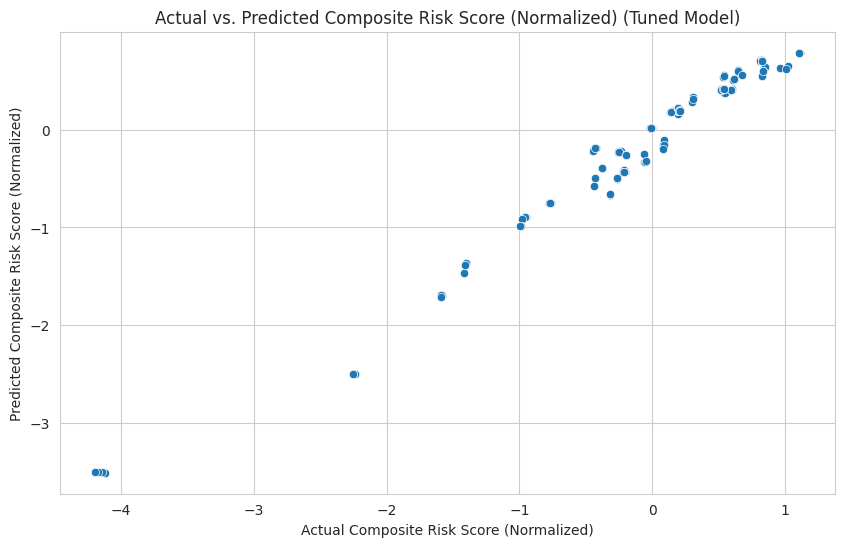

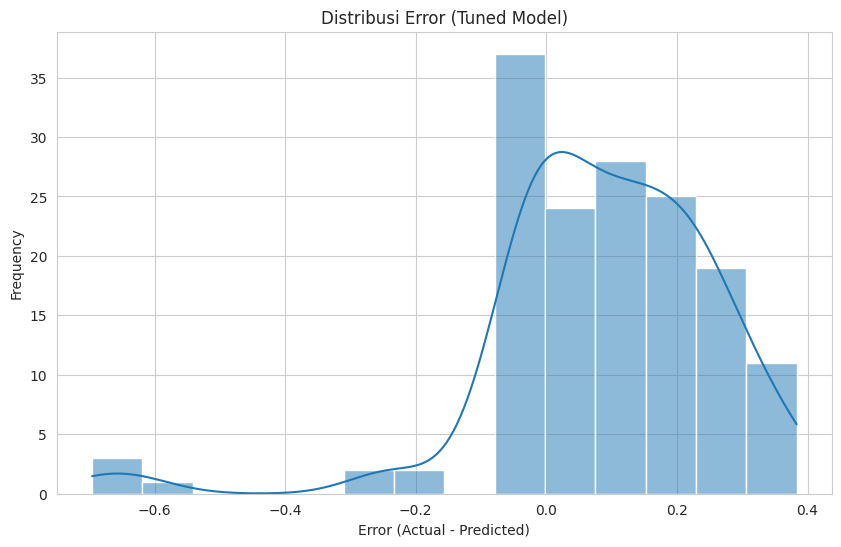

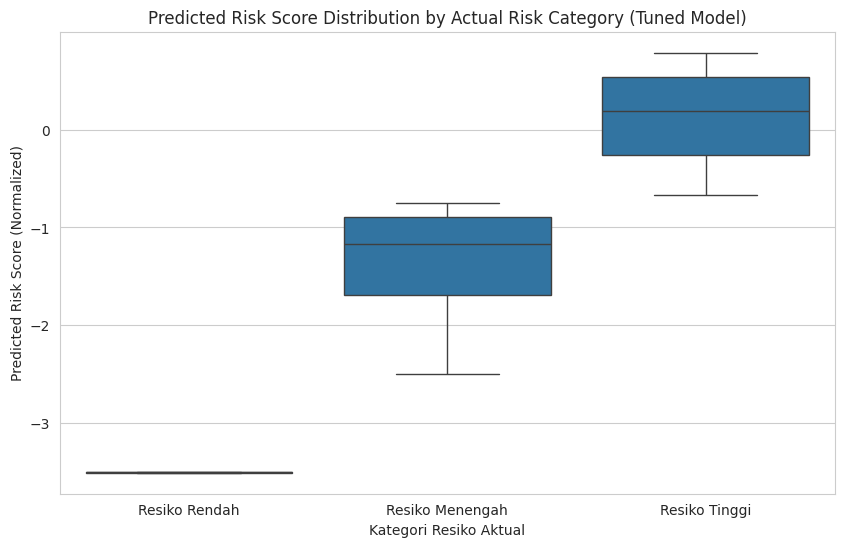

In [37]:
# Visualisasi actual dan nilai prediksi
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_tuned) # Use y_pred_tuned
plt.title('Actual vs. Predicted Composite Risk Score (Normalized) (Tuned Model)') # Updated title
plt.xlabel('Actual Composite Risk Score (Normalized)')
plt.ylabel('Predicted Composite Risk Score (Normalized)')
plt.show()

#Distribusi Error
errors = y_test - y_pred_tuned # Use y_pred_tuned for errors
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.title('Distribusi Error (Tuned Model)') # Updated title
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# Analisis berdasarkan kuartil atau rentang risiko

# Membagi y_test menjadi 3 kategori (approksimasi)
y_test_quantiles = y_test.quantile([0.33, 0.66])
low_risk_mask = y_test <= y_test_quantiles.iloc[0]
medium_risk_mask = (y_test > y_test_quantiles.iloc[0]) & (y_test <= y_test_quantiles.iloc[1])
high_risk_mask = y_test > y_test_quantiles.iloc[1]

# Dataframe untuk Boxplot
boxplot_data = pd.DataFrame({
    'Predicted_Risk_Score': y_pred_tuned,
    'Actual_Risk_Category': pd.cut(y_test, bins=3, labels=['Resiko Rendah', 'Resiko Menengah', 'Resiko Tinggi'])
})


plt.figure(figsize=(10, 6))
sns.boxplot(x='Actual_Risk_Category', y='Predicted_Risk_Score', data=boxplot_data)
plt.title('Predicted Risk Score Distribution by Actual Risk Category (Tuned Model)') # Updated title
plt.xlabel('Kategori Resiko Aktual')
plt.ylabel('Predicted Risk Score (Normalized)')
plt.show()

# Interpretasi Model dengan Explainable AI (XAI)

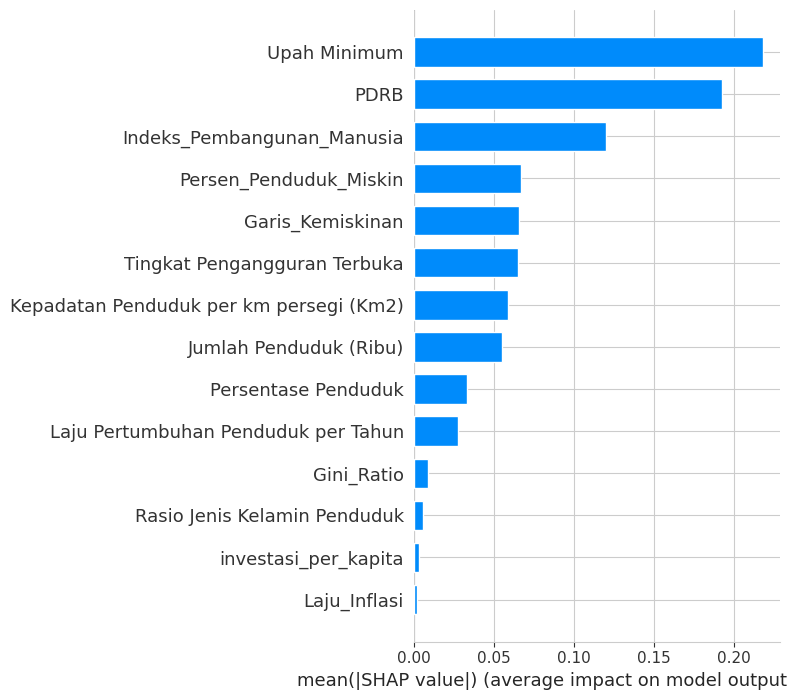

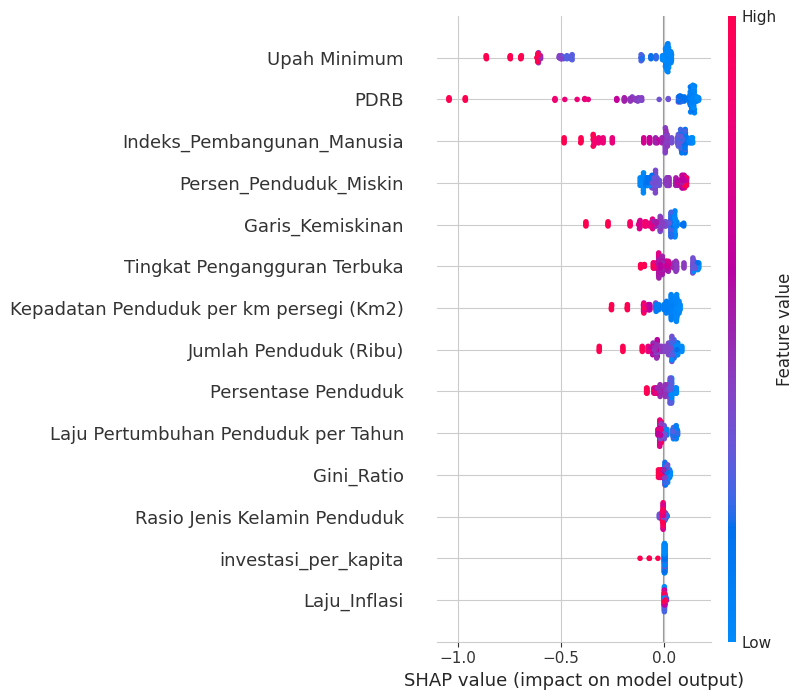

In [38]:
# Inisialisasi SHAP explainer
explainer = shap.TreeExplainer(tuned_xgb_model)

# Hitung SHAP values pada data uji
shap_values = explainer.shap_values(X_test)

# Visualisasi ringkasan SHAP values (Summary Plot)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Visualisasi SHAP values (beeswarm plot)
shap.summary_plot(shap_values, X_test)

#Uji Kekokohan dengan bootstraping

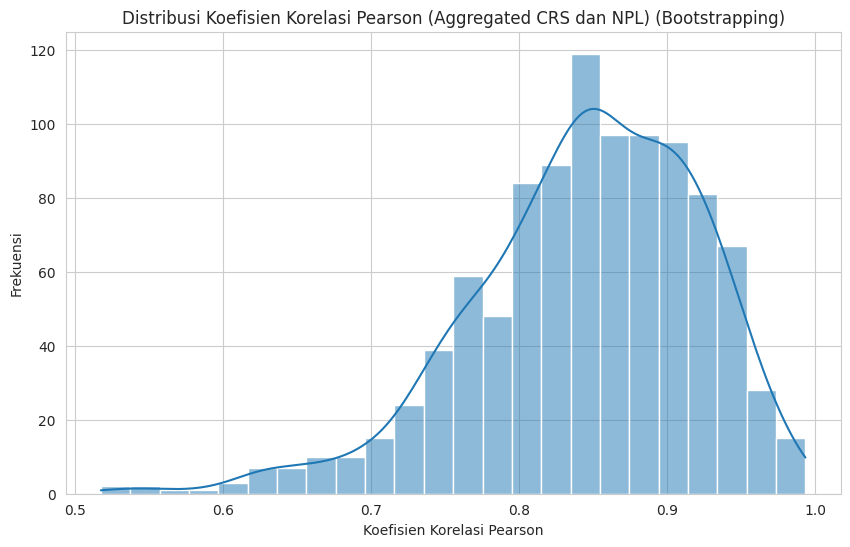

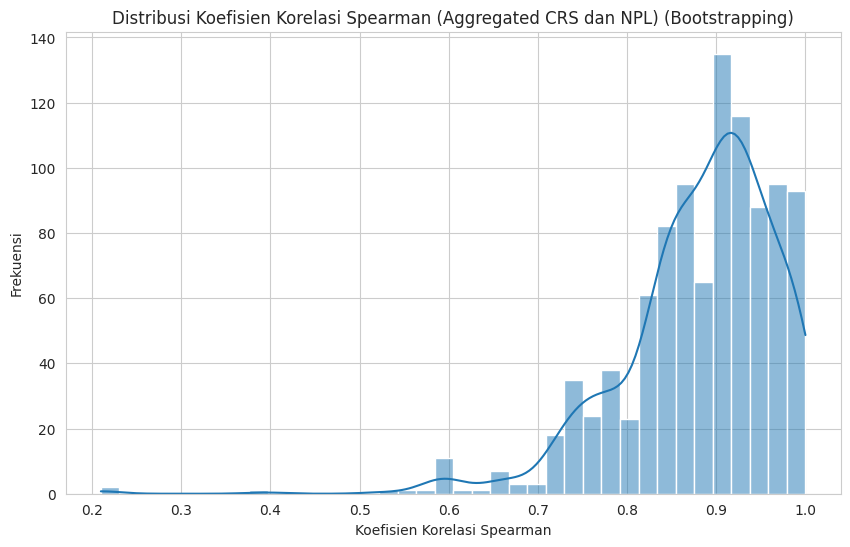

Interval Kepercayaan 95% untuk Korelasi Pearson (Aggregated CRS dan NPL): (0.6638, 0.9667)
Interval Kepercayaan 95% untuk Korelasi Spearman (Aggregated CRS dan NPL): (0.6666, 1.0000)


In [41]:
# Gabungkan data Composite Risk Score yang diagregasi dan NPL untuk bootstrapping
bootstrap_data_agg_npl = merged_correlation_df[['Provincial_Weighted_Risk_Score', 'NPL']].dropna()


n_bootstraps_agg_npl = 1000
pearson_correlations_agg_npl = []
spearman_correlations_agg_npl = []

for _ in range(n_bootstraps_agg_npl):
    # Ambil sampel acak dengan penggantian
    sample_df_agg_npl = bootstrap_data_agg_npl.sample(n=len(bootstrap_data_agg_npl), replace=True)

    # Hitung korelasi pada sampel
    pearson_corr_agg_npl, _ = pearsonr(sample_df_agg_npl['Provincial_Weighted_Risk_Score'], sample_df_agg_npl['NPL'])
    spearman_corr_agg_npl, _ = spearmanr(sample_df_agg_npl['Provincial_Weighted_Risk_Score'], sample_df_agg_npl['NPL'])

    pearson_correlations_agg_npl.append(pearson_corr_agg_npl)
    spearman_correlations_agg_npl.append(spearman_corr_agg_npl)

# Visualisasi distribusi koefisien korelasi Pearson
plt.figure(figsize=(10, 6))
sns.histplot(pearson_correlations_agg_npl, kde=True)
plt.title('Distribusi Koefisien Korelasi Pearson (Aggregated CRS dan NPL) (Bootstrapping)')
plt.xlabel('Koefisien Korelasi Pearson')
plt.ylabel('Frekuensi')
plt.show()

# Visualisasi distribusi koefisien korelasi Spearman
plt.figure(figsize=(10, 6))
sns.histplot(spearman_correlations_agg_npl, kde=True)
plt.title('Distribusi Koefisien Korelasi Spearman (Aggregated CRS dan NPL) (Bootstrapping)')
plt.xlabel('Koefisien Korelasi Spearman')
plt.ylabel('Frekuensi')
plt.show()

# Analisis: Hitung interval kepercayaan 95%
pearson_ci_lower_agg_npl = np.percentile(pearson_correlations_agg_npl, 2.5)
pearson_ci_upper_agg_npl = np.percentile(pearson_correlations_agg_npl, 97.5)
spearman_ci_lower_agg_npl = np.percentile(spearman_correlations_agg_npl, 2.5)
spearman_ci_upper_agg_npl = np.percentile(spearman_correlations_agg_npl, 97.5)

print(f"Interval Kepercayaan 95% untuk Korelasi Pearson (Aggregated CRS dan NPL): ({pearson_ci_lower_agg_npl:.4f}, {pearson_ci_upper_agg_npl:.4f})")
print(f"Interval Kepercayaan 95% untuk Korelasi Spearman (Aggregated CRS dan NPL): ({spearman_ci_lower_agg_npl:.4f}, {spearman_ci_upper_agg_npl:.4f})")

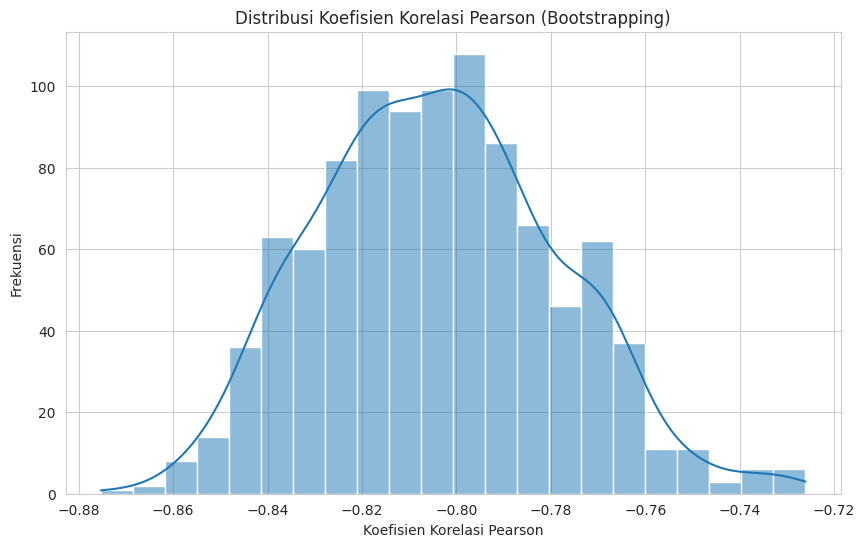

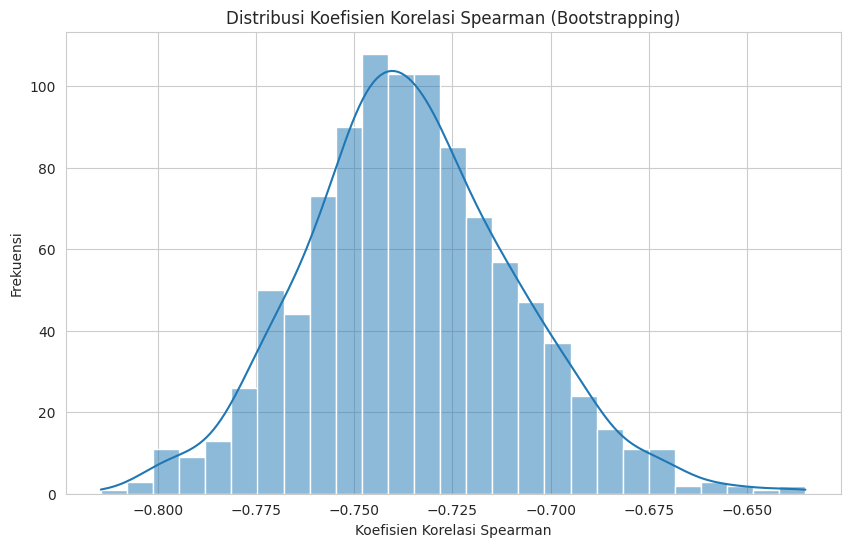

Interval Kepercayaan 95% untuk Korelasi Pearson: (-0.8482, -0.7531)
Interval Kepercayaan 95% untuk Korelasi Spearman: (-0.7866, -0.6771)


In [39]:
# Gabungkan data Composite Risk Score dan Jumlah Perusahaan Kecil untuk bootstrapping
bootstrap_data = df_merged_jpk_cleaned[['Composite_Risk_Score_Normalized', 'Jumlah Perusahaan Kecil']].dropna()


n_bootstraps = 1000
pearson_correlations = []
spearman_correlations = []

for _ in range(n_bootstraps):
    # Ambil sampel acak dengan penggantian
    sample_df = bootstrap_data.sample(n=len(bootstrap_data), replace=True)

    # Hitung korelasi pada sampel
    pearson_corr, _ = pearsonr(sample_df['Composite_Risk_Score_Normalized'], sample_df['Jumlah Perusahaan Kecil'])
    spearman_corr, _ = spearmanr(sample_df['Composite_Risk_Score_Normalized'], sample_df['Jumlah Perusahaan Kecil'])

    pearson_correlations.append(pearson_corr)
    spearman_correlations.append(spearman_corr)

# Visualisasi distribusi koefisien korelasi Pearson
plt.figure(figsize=(10, 6))
sns.histplot(pearson_correlations, kde=True)
plt.title('Distribusi Koefisien Korelasi Pearson (Bootstrapping)')
plt.xlabel('Koefisien Korelasi Pearson')
plt.ylabel('Frekuensi')
plt.show()

# Visualisasi distribusi koefisien korelasi Spearman
plt.figure(figsize=(10, 6))
sns.histplot(spearman_correlations, kde=True)
plt.title('Distribusi Koefisien Korelasi Spearman (Bootstrapping)')
plt.xlabel('Koefisien Korelasi Spearman')
plt.ylabel('Frekuensi')
plt.show()

# Analisis: Hitung interval kepercayaan 95%
pearson_ci_lower = np.percentile(pearson_correlations, 2.5)
pearson_ci_upper = np.percentile(pearson_correlations, 97.5)
spearman_ci_lower = np.percentile(spearman_correlations, 2.5)
spearman_ci_upper = np.percentile(spearman_correlations, 97.5)

print(f"Interval Kepercayaan 95% untuk Korelasi Pearson: ({pearson_ci_lower:.4f}, {pearson_ci_upper:.4f})")
print(f"Interval Kepercayaan 95% untuk Korelasi Spearman: ({spearman_ci_lower:.4f}, {spearman_ci_upper:.4f})")

# Ringkasan Analisis dan Kesimpulan

##Ringkasan Temuan

Berdasarkan analisis yang telah dilakukan:

*   **Agregasi Risk Score Provinsi:** Kami berhasil mengagregasi Composite Risk Score dari tingkat kabupaten/kota ke tingkat provinsi dengan pembobotan menggunakan PDRB. Hasil agregasi ini menunjukkan tren tertentu dari waktu ke waktu.
*   **Korelasi dengan NPL:** Visualisasi dan uji korelasi Pearson serta Spearman antara Aggregated Composite Risk Score Provinsi dan NPL dengan lag 2 kuartal menunjukkan korelasi yang kuat dan signifikan.
    *   Ini menunjukkan bahwa perubahan pada Composite Risk Score cenderung diikuti oleh perubahan pada NPL dua kuartal berikutnya.
*   **Korelasi dengan Jumlah Perusahaan Kecil:** Uji korelasi Pearson dan Spearman antara Composite Risk Score (tingkat kabupaten/kota) dan Jumlah Perusahaan Kecil juga menunjukkan korelasi yang kuat dan signifikan, namun negatif.
    *   Ini mengindikasikan bahwa semakin tinggi Composite Risk Score (semakin tinggi risiko), cenderung semakin sedikit Jumlah Perusahaan Kecil.
*   **Uji Kekokohan (Bootstrapping):** Hasil bootstrapping untuk korelasi antara Composite Risk Score dan Jumlah Perusahaan Kecil menunjukkan distribusi koefisien korelasi Pearson dan Spearman yang terpusat jauh dari nol. Interval kepercayaan 95% tidak mencakup nol:
    *   Ini memperkuat keyakinan bahwa korelasi yang diamati cukup kokoh dan bukan kebetulan.

##Jawaban atas Hipotesis

Berdasarkan temuan dari analisis korelasi dan uji kekokohan, kami memiliki bukti statistik yang sangat kuat untuk menolak hipotesis nol. hipotesis bahwa "terdapat hubungan yang signifikan antara Composite Risk Score (baik di tingkat kabupaten/kota maupun provinsi) dengan indikator ekonomi tertentu, seperti NPL (Non-Performing Loan) dan Jumlah Perusahaan Kecil" **didukung oleh data**.

Ditemukannya korelasi yang kuat dan signifikan, serta hasil uji kekokohan yang meyakinkan, menunjukkan adanya asosiasi yang jelas antara Composite Risk Score dengan NPL (dengan lag waktu) dan Jumlah Perusahaan Kecil.

##Peringatan: Korelasi Bukan Kausalitas

**Penting untuk dicatat bahwa meskipun analisis ini menemukan korelasi yang kuat dan signifikan, ini TIDAK secara otomatis membuktikan adanya hubungan sebab-akibat (kausalitas) antara Composite Risk Score dan NPL atau Jumlah Perusahaan Kecil.** Korelasi hanya mengukur sejauh mana dua variabel bergerak bersama. Mungkin ada faktor lain yang tidak termasuk dalam analisis ini yang berperan dalam hubungan tersebut. Diperlukan penelitian lebih lanjut, mungkin dengan metode yang berbeda (misalnya, analisis kausalitas atau model ekonometrika), untuk dapat menarik kesimpulan tentang sebab-akibat.

In [40]:
#scaler_step = ('scaler', StandardScaler())
#model_step = ('xgb_model', tuned_xgb_model)

# Create the pipeline without the PCA step
#full_pipeline = Pipeline([
#    scaler_step,
#    model_step
#])

#exclude_cols = ['kabupaten_kota', 'tahun', 'kuartal', 'Proksi Inflasi','nama_kabupaten_kota','Jumlah Perusahaan Kecil','Jumlah Perusahaan']
#X_train_raw = df_train.drop(columns=exclude_cols, errors='ignore')
#full_pipeline.fit(X_train_raw, y_train)
#joblib.dump(full_pipeline, 'risk_prediction_pipeline.pkl')

#print("Pipeline saved successfully!")